In [121]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.fft import fft, fftfreq
from math import pi 
from scipy import stats 
from scipy import special

In [122]:
def generate_data(N_train = 2 ** 12, N_test = 2 ** 14): 
    
    def f(x):
        a = 1 / 100
        si, ci = special.sici(x / a)
        return si * np.exp(-x ** 2 / 2)

    x_train = np.random.normal(0, 1, N_train)
    x_train = np.reshape(x_train, (N_train, 1))
    y_train = f(x_train)
    
    x_validation = np.random.normal(0, 1, N_train)
    x_validation = np.reshape(x_validation, (N_train, 1))
    y_validation = f(x_validation)
    
    x_test = np.linspace(-25 * pi, 25 * pi, N_test).reshape(N_test, 1)
    x_test = np.reshape(x_test, (N_test, 1))
    y_test = f(x_test)
    
    plt.plot(x_test, y_test)
    plt.title('y_test')
    plt.show()
    
    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [123]:
# compute cut-off frequency w0

def method_1_w0(x, y, px): 
    
    # calculate f_p
    dx = x[1] - x[0]
    E_y = np.sum(px * y * dx)
    fp = np.sqrt(px) * (y - E_y)

    # fast Fourier transform
    N = len(x)
    yf = np.fft.fft(fp, axis=0)
    
    # the minimization function 
    dw = 2*pi/N/dx 
    K = np.linspace(-N/2, N/2-1, N)
    f2 = np.abs(yf * dx)**2 * dw

    # compute the difference 
    var_f = np.sum(f2)
    n0 = range(0, int(N/2))
    e_diff = np.zeros(int(N/2))
    
    for k in n0:
        if k>=0 and k<=N/2-1: 
            if k==0: 
                e_low = f2[k]
                e_high = var_f - e_low
            else:
                e_low = f2[0] + 2*np.sum(f2[1:k])
                e_high = var_f - e_low
            e_diff[k] = np.abs(e_low-e_high)
        else: 
            print("index error")
    
    # calculate the cut-off w0
    e_diff_min = min(e_diff)
    w0 = np.argmin(e_diff) 
    
    return w0, var_f

In [124]:
def method_1(var_f, w0, x_test, y_test, pred, px): 
    
    N = len(x_test) 
    # compute r
    r = y_test - pred

    # calculate r_p
    dx = x_test[1] - x_test[0]
    r_mean = np.sum(px * r * dx)
    rp = np.sqrt(px) * (r - r_mean) 

    # Fourier transform 
    rf = np.fft.fft(rp, axis=0)
    rf = np.reshape(rf, (N, 1))

    # compute sum_low
    dw = 2*pi/N/dx 
    r2 = np.abs(rf * dx)**2 * dw
    w0 = int(w0)
    if w0==0: 
        e_low_sum = r2[w0]
        e_high_sum = sum(r2) - e_low_sum
    else:
        e_low_sum = r2[0] + 2*np.sum(r2[1:w0])
        e_high_sum = sum(r2) - e_low_sum

    # compute SB
    e_low = e_low_sum/var_f
    e_high = e_high_sum/var_f
    
    SB = (e_high - e_low) / (e_high + e_low)
    
    return SB

In [125]:
def FVU_compute(y, pred): 
    r = y - pred 
    var_r = np.var(r)
    var_f = np.var(y)
    FVU = var_r/var_f 
    return FVU 

In [126]:
import tensorflow as tf 
from tensorflow import keras 

In [127]:
# define the keras model 
K = 64
input_layer = keras.Input(shape = (1, ))
hidden_layer_1 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_2 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_3 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_4 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
hidden_layer_5 = keras.layers.Dense(units = K, 
                                    activation = 'relu', 
                                    kernel_initializer=tf.keras.initializers.he_normal, 
                                    bias_initializer=tf.keras.initializers.Zeros())
output_layer = keras.layers.Dense(units = 1, 
                                    use_bias = False)
model = keras.Sequential([input_layer, 
                          hidden_layer_1,
                          hidden_layer_2, 
                          hidden_layer_3, 
                          hidden_layer_4, 
                          hidden_layer_5, 
                          output_layer])

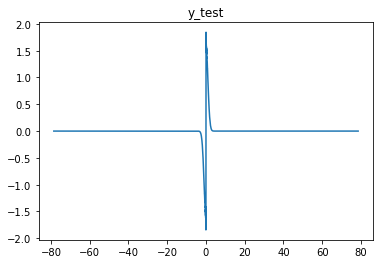

57


In [128]:
# implement experiment 2

N_train = 2 ** 12
N_test = 2 ** 14

seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

x_train, y_train, x_validation, y_validation, x_test, y_test = generate_data()

# Save training values for training error evaluation
x_train_eval = x_train
y_train_eval = y_train

# Normalize the training data
x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis=0)
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

px = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * (((x_test) / x_std) ** 2))
px_train = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_train / x_std) ** 2))
px_validation = 1 / x_std / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * ((x_validation / x_std) ** 2))

w0, var = method_1_w0(x_test, y_test, px)
print(w0)


End of epoch  0, Training error 0.14130744573417048

End of epoch  10, Training error 0.002854794755450565

End of epoch  20, Training error 0.0017166250849049785

End of epoch  30, Training error 0.001460045364630487

End of epoch  40, Training error 0.0013449111574262297

End of epoch  50, Training error 0.0012464031211586318

End of epoch  60, Training error 0.001191922277510828

End of epoch  70, Training error 0.0011449954084401359

End of epoch  80, Training error 0.0011057463716877772

End of epoch  90, Training error 0.0010703203724552256

End of epoch  100, Training error 0.0010375150454334638

End of epoch  110, Training error 0.0010110906121344686

End of epoch  120, Training error 0.0009733748706572493

End of epoch  130, Training error 0.0009506032015030229

End of epoch  140, Training error 0.0009305594813133571

End of epoch  150, Training error 0.0009132665003687931

End of epoch  160, Training error 0.0008980377675291025

End of epoch  170, Training error 0.0008852617

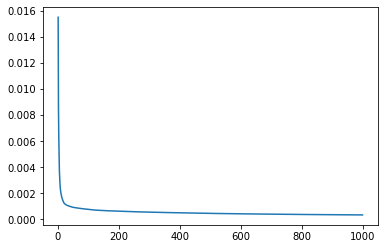

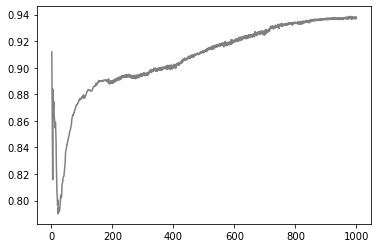

In [129]:
batch_size = 32
epochs = 1000
num_evals=100
mod = int(epochs / num_evals)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1).batch(batch_size)

loss_fn=tf.keras.losses.mean_squared_error
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

def nn_predict(x):
    x = (x - x_mean) / x_std
    beta = model(x) * y_std + y_mean
    return beta.numpy()
    
FVU = []
FVU_validation = []
SB_M1 = []

# Training step
for epoch in range(epochs):

    # Train the Network
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Record the loss computations
        with tf.GradientTape() as tape:
            pred = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, pred)
        # Compute and apply gradients
        model.grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(model.grads, model.trainable_weights))

    # Print the training loss for every tenth epoch
    if epoch % 10 == 0:
        print("\nEnd of epoch  " + str(epoch) + ", Training error " +
                      str(np.mean((y_train_eval - nn_predict(x_train_eval)) ** 2))) 
                      
    pred = nn_predict(x_train_eval)
    pred_validation = nn_predict(x_validation)
    FVU = np.append(FVU, FVU_compute(y_train, pred))
    FVU_validation = np.append(FVU_validation, FVU_compute(y_validation, pred_validation))
    
    w0, var = method_1_w0(x_test, y_test, px)
    pred_test = nn_predict(x_test)
    SB_ = method_1(var, w0, x_test, y_test, pred_test, px)
    SB_M1 = np.append(SB_M1, SB_)
    
t_vec = np.arange(0, epochs)
plt.plot(t_vec[1:], FVU_validation[1:])
plt.show()

plt.plot(t_vec[1:], SB_M1[1:], color='0.5', label="Method 1")
plt.show()

In [130]:
class Compute_SB_Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        
        # predicting the data
        x_norm = (x_test - x_mean)/x_std
        pred = model.predict(x_norm)
        pred = pred * y_std + y_mean
        pred = np.reshape(pred, (N_test, 1))

        FVU = FVU_compute(y_test, pred)
        SB = method_1(var, w0, x_test, y_test, pred, px)
        
        i = int(epoch - 1)
        FVU_list[i] = FVU
        SB_list[i] = SB 
        
        #print(SB)

In [131]:
# compling the model 
adam = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer = 'adam', loss = 'mse')

N_epoch = 1000
FVU_list = np.zeros(N_epoch)
SB_list = np.zeros(N_epoch)

SB_callback = Compute_SB_Callback()
tf.random.set_seed(seed)
beta = model.fit(x_train, y_train, epochs=N_epoch, batch_size=32, callbacks=[SB_callback])

my_loss = beta.history['loss']

Epoch 1/1000
128/128 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 2/1000
128/128 [==============================] - 0s 3ms/step - loss: 4.9901e-04
Epoch 3/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.3210e-04
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: 4.6511e-04
Epoch 5/1000
128/128 [==============================] - 0s 2ms/step - loss: 4.3122e-04
Epoch 6/1000
128/128 [==============================] - 0s 2ms/step - loss: 6.3256e-04
Epoch 7/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.6304e-04
Epoch 8/1000
128/128 [==============================] - 0s 2ms/step - loss: 4.2179e-04
Epoch 9/1000
128/128 [==============================] - 0s 2ms/step - loss: 4.0870e-04
Epoch 10/1000
128/128 [==============================] - 0s 2ms/step - loss: 3.8562e-04
Epoch 11/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 12/1000
128/128 [==========================

https://www.tensorflow.org/guide/keras/custom_callback

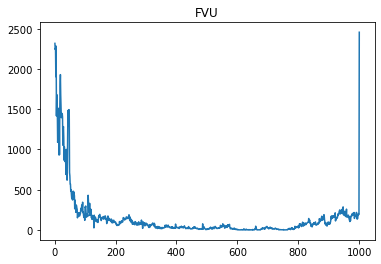

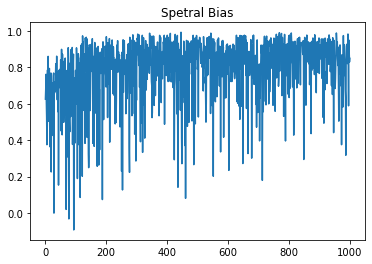

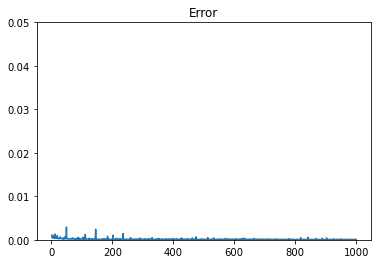

In [132]:
epoch_list = np.arange(1, N_epoch+1)

plt.plot(epoch_list, FVU_list)
#plt.ylim(0,1)
plt.title('FVU')
plt.show()

plt.plot(epoch_list, SB_list)
plt.title('Spetral Bias')
plt.show()

plt.plot(epoch_list, my_loss)
plt.title('Error')
plt.ylim(0,0.05)
plt.show()